In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from torchvision.datasets import VOCSegmentation

# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),
])

# Load the Pascal VOC 2012 dataset
train_dataset = VOCSegmentation(root='data', year='2012', image_set='train', download=True, transform=transform, target_transform=transform)
val_dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

0.0%

100.0%


Extracting data\VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data


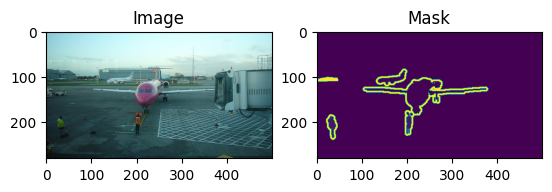

In [6]:
def visualize_sample(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title('Image')
    ax[1].imshow(mask.permute(1, 2, 0))
    ax[1].set_title('Mask')
    plt.show()

# Get a sample from the training dataset
image, mask = train_dataset[0]
visualize_sample(image, mask)

In [4]:
# Number of images in the training dataset
num_train_images = len(train_dataset)
print(f'Number of images in the training dataset: {num_train_images}')

# Number of batches in the training DataLoader
num_train_batches = len(train_loader)
print(f'Number of batches in the training DataLoader: {num_train_batches}')

# Number of images in the validation dataset
num_val_images = len(val_dataset)
print(f'Number of images in the validation dataset: {num_val_images}')

# Number of batches in the validation DataLoader
num_val_batches = len(val_loader)
print(f'Number of batches in the validation DataLoader: {num_val_batches}')


Number of images in the training dataset: 1464
Number of batches in the training DataLoader: 366
Number of images in the validation dataset: 1449
Number of batches in the validation DataLoader: 363


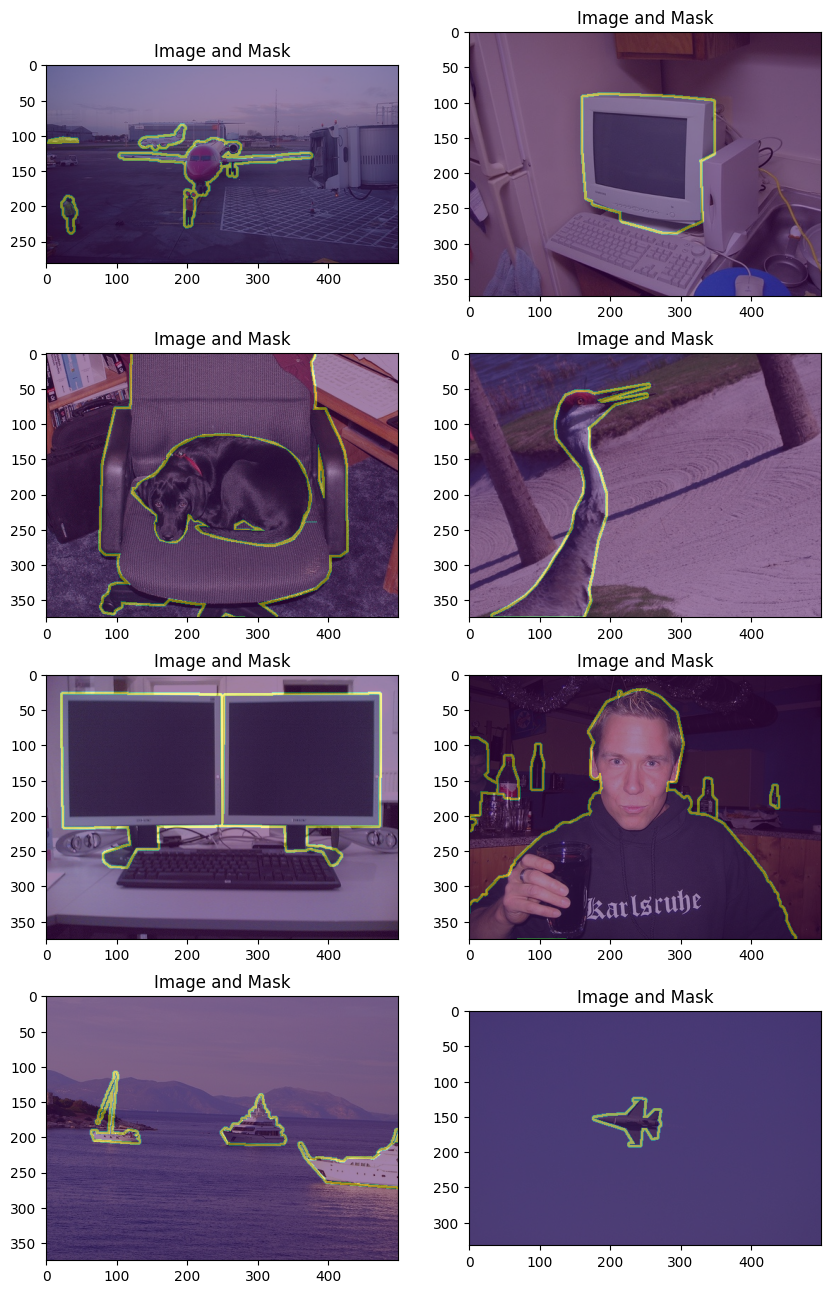

In [7]:
def visualize_samples(images, masks, num_samples=8):
    _, ax = plt.subplots(num_samples // 2, 2, figsize=(10, num_samples * 2))
    for i in range(num_samples):
        ax[i // 2, i % 2].imshow(images[i].permute(1, 2, 0))
        ax[i // 2, i % 2].imshow(masks[i].permute(1, 2, 0), alpha=0.5)
        ax[i // 2, i % 2].set_title('Image and Mask')
    plt.show()

# Get samples from the training dataset
images, masks = zip(*[train_dataset[i] for i in range(8)])
visualize_samples(images, masks)

In [8]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))  # VOC has 21 classes

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

c:\Users\tudor\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tudor\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\tudor/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth
100.0%


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).long()
        
        optimizer.zero_grad()
        
        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

print('Training complete')

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 332] at entry 0 and [3, 435, 450] at entry 1

In [ ]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device).long()
        
        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1))
        print(f'Validation Loss: {loss.item()}')
        
        # Visualize some predictions
        preds = torch.argmax(outputs, dim=1)
        for i in range(images.size(0)):
            visualize_sample(images[i].cpu(), preds[i].cpu())
